# 涉及到的数据集包含:CIFAR10，DVSGesture

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# # InteractiveShell.ast_node_interactivity = "last_expr"

### 查看cifar10数据集

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 定义数据变换
transform = transforms.Compose(
    [transforms.ToTensor(),  # 将图片转换为Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
# #训练集
trainset=torchvision.datasets.CIFAR10(root=r'../data',train=True,download=False,transform=transform)
# 测试集
testset=torchvision.datasets.CIFAR10(root=r'../data',train=False,download=False,transform=transform)

In [4]:
 # 定义batch_size和num_workers
batch_size = 4
num_workers = 0  # Windows系统不支持多进程，所以num_workers应设为0
# 创建DataLoader对象
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=num_workers)
# 定义类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].


Text(0.5, 1.0, 'plane')

(-0.5, 31.5, 31.5, -0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


Text(0.5, 1.0, 'car')

(-0.5, 31.5, 31.5, -0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52156866..0.8980392].


Text(0.5, 1.0, 'plane')

(-0.5, 31.5, 31.5, -0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.81960785].


Text(0.5, 1.0, 'bird')

(-0.5, 31.5, 31.5, -0.5)

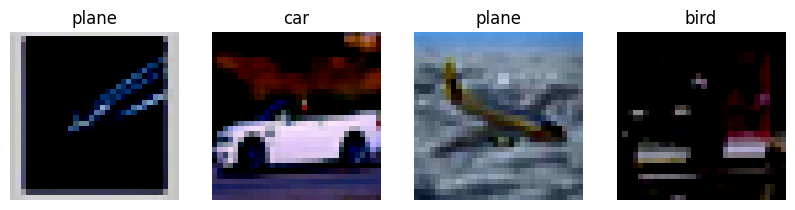

     plane        car      plane       bird


In [6]:
# 获取一些随机训练图像
dataiter = iter(trainloader)
images, labels = next(dataiter) #注意点，由于版本不同，应该使用next()来迭代dataiter对象

# 展示图像和标签
#ncols 生成图片数量
fig, axes = plt.subplots(figsize=(10, 5), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(classes[labels[i]])# 设置图片的标签
    ax.axis('off')
plt.show()

# 打印标签label
print(' '.join('%10s'% classes[labels[i]]for i in range(4)))

注意：上面代码是有报错的，Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].

In [10]:
images[1].shape
data = images[1]
print(f"Min: {data.min()}, Max: {data.max()}")

torch.Size([3, 32, 32])

Min: -0.9686274528503418, Max: 1.0


In [11]:
i
images[i].shape
labels[i]

3

torch.Size([3, 32, 32])

tensor(2)

这里就对数据范围进行了变换

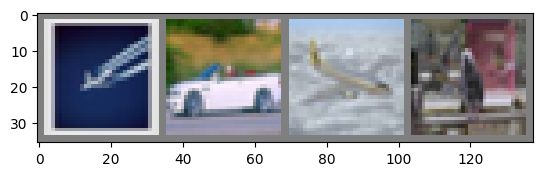

     plane        car      plane       bird


In [12]:
# 构建展示图片的函数
def imshow(img):
    img=img/2+0.5
    # 将tensor转化成numpy格式的数据
    npimg=img.numpy()
    # 生成一张图片 位于trainset第一张图片
    # img = torchvision.utils.make_grid(trainset[1][0]).numpy()
#     #维度转换
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# 展示图片
imshow(torchvision.utils.make_grid(images))

# 打印标签label
print(' '.join('%10s'% classes[labels[i]]for i in range(4)))


### 对DVS Gesture进行分类

In [21]:
import torch
from spikingjelly.activation_based import surrogate
from spikingjelly.activation_based import encoding
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from spikingjelly.activation_based import monitor, neuron, functional, layer
import sys
import numpy as np
from torch import amp
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture

In [ ]:
# 测试集评估函数
def evaluates3(name, model, data_loader, num_classes = 11):
    """
    这个测试集函数用于具有时间维度的数据，且网络的设计也必须是针对具有时间维度的数据。
    """
    acc = 0
    losss = 0
    data_num = 0
    _ = model.eval()

    datas = tqdm(iter(data_loader),file=sys.stdout)
    with torch.no_grad():
        for data, targets in datas:
            data = data.to(device)
            data = data.transpose(0, 1)
            targets = targets.to(device)
            label_onehot = F.one_hot(targets, num_classes).float()  # 将标签变为独热编码

            out_fr = model(data) # 将每次输出的脉冲进行相加

            loss = F.mse_loss(out_fr, label_onehot)
            data_num += targets.numel()
            losss += loss.item() * targets.numel()
            # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            acc += (out_fr.argmax(1) == targets).float().sum().item()
            
            functional.reset_net(model)

#             del data, targets,loss
#             torch.cuda.empty_cache()
    
    print(f"{name} All Acc: {acc/data_num * 100:.2f}%")
    print(f"{name} All Loss: {losss/data_num:.4f}")
#     print("\n")
    return acc/data_num, losss/data_num

普通网络

In [16]:
class DVSGestureNet(nn.Module):
    def __init__(self, channels=128):
        super().__init__()

        conv = []
        for i in range(5):
            if conv.__len__() == 0:
                in_channels = 2
            else:
                in_channels = channels

            conv.append(layer.Conv2d(in_channels, channels, kernel_size=3, padding=1, bias=False))
            conv.append(layer.BatchNorm2d(channels))
            conv.append(neuron.IFNode(surrogate_function=surrogate.ATan()))
#             neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan())   两种神经元的替换使用
            conv.append(layer.MaxPool2d(2, 2))


        self.conv_fc = nn.Sequential(
            *conv,
            layer.Flatten(),
            layer.Dropout(0.5),
            layer.Linear(channels * 4 * 4, 512),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Dropout(0.5),
            layer.Linear(512, 110),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.VotingLayer(10)
        )
        # 设置网络的模式，是单步还是多步，一般都是多步
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        return self.conv_fc(x)

In [22]:
root_dir = r'../data/DVS128Gesture'
T = 20
batch_size=16
lr=1e-3
num_epochs = 50
num_classes = 11

train_set = DVS128Gesture(root=root_dir, train=True, data_type='frame', frames_number=T, split_by='number')
test_set = DVS128Gesture(root=root_dir, train=False, data_type='frame', frames_number=T, split_by='number')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

# 设备选择使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 初始化网络 
net = DVSGestureNet(channels=32).to(device)
# 使用Adam优化器
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.
The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.


DataLoader打包数据的话，第0维是batch维度，故读取的数据维度是[N,T,C,H,W],如下面打印所示，但是spikingjelly的多步模式要求输入数据的维度shape=[T,N,C,H,W],所以要进行转换一下，

In [18]:
# # shape = [N, T, C, H, W]
# for x,y in train_loader:
#     print(x.shape,y.shape)
#     break

torch.Size([16, 20, 2, 128, 128]) torch.Size([16])


In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        # 将数据维度由  [N, T, C, H, W] 变为  [T, N, C, H, W]
        img = img.transpose(0, 1)
        label = label.to(device)
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img).mean(0) 
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img).mean(0)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_models/DVS_lr0.001_DVSGestureNet.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n") 

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

sew_resnet

In [ ]:
# SEW_ResNet原始网络及面对不同数据集所进行的网络变换以及数据操作的变换
class BasicBlock(nn.Module):
    """
    实现ResNet网络的第一个基础架构
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(BasicBlock, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('SpikingBasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in SpikingBasicBlock")

        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=False),
            norm_layer(planes),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False),
            norm_layer(planes),
            neuron.IFNode(surrogate_function=surrogate.ATan()))

        self.downsample = downsample
        
        # 设置所有的层为多步模式
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
#         print(out.shape)
#         print(identity.shape)
        if self.connect_f == 'ADD':
            out += identity
        elif self.connect_f == 'AND':
            out *= identity
        elif self.connect_f == 'IAND':
            out = identity * (1. - out)
        else:
            raise NotImplementedError(self.connect_f)

        return out


class Bottleneck(nn.Module):
    """
    实现ResNet网络的瓶颈架构
    """
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(Bottleneck, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, width, kernel_size=1, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, groups = groups, dilation = dilation, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer3 = nn.Sequential(
            layer.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False),
            norm_layer(planes * self.expansion),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
   
        self.downsample = downsample
        
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        if self.connect_f == 'ADD':
            out += identity
        elif self.connect_f == 'AND':
            out *= identity
        elif self.connect_f == 'IAND':
            out = identity * (1. - out)
        else:
            raise NotImplementedError(self.connect_f)

        return out

# 对这两个架构的最后一层中的 BN 层进行设置，权重为0，且当连接方式为AND时，偏差置为1
def zero_init_blocks(net: nn.Module, connect_f: str):
    for m in net.modules():
        if isinstance(m, Bottleneck):
            nn.init.constant_(m.layer3.module[1].weight, 0)
            if connect_f == 'AND':
                nn.init.constant_(m.layer3.module[1].bias, 1)
        elif isinstance(m, BasicBlock):
            nn.init.constant_(m.layer2.module[1].weight, 0)
            if connect_f == 'AND':
                nn.init.constant_(m.layer2.module[1].bias, 1)

# 设计SEWResNet网络，原始的网络
class SEWResNet(nn.Module):

    def __init__(self, block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, T=4, connect_f=None, drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0):
        """
        data_type：输入的数据是没有时间维度的，还是具有时间维度的
        net_type：使用sew_resnet还是sew_resnet2
        """
        super(SEWResNet, self).__init__()
        
        # 是否使用扩张率代替步长，一般这个操作应该用不上
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.T = T
        self.connect_f = connect_f
        self.groups = groups
        self.base_width = width_per_group
        self.drops = drops
        self.data_type = data_type
        self.net_type = net_type
        
        self.layer01 = nn.Sequential(
            layer.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            norm_layer(self.inplanes))
        
        self.layer02 = nn.Sequential(
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=3, stride=2, padding=1))
        functional.set_step_mode(self.layer02, step_mode='m')

        self.layer1 = self._make_layer(block, 64, layers[0], connect_f=connect_f)
        self.dp1 = layer.Dropout(p[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0], connect_f=connect_f)
        self.dp2 = layer.Dropout(p[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1], connect_f=connect_f)
        self.dp3 = layer.Dropout(p[2])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2], connect_f=connect_f)
        self.dp4 = layer.Dropout(p[3])
        self.avgpool = layer.AdaptiveAvgPool2d((1, 1))
        # 最后一层的通道输出需要乘以扩张率
        self.fc = layer.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, layer.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (layer.BatchNorm2d, layer.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            zero_init_blocks(self, connect_f)
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, connect_f=None):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        # 使用扩张率代替步长
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # 步长不等于1的时候，当然我们需要使用下采样层，当步长为1，但是在一个Block中，输入通道数不等于输出通道数的时候，
        # 我们仍然需要使用下采样层，因为我们每一个block块的输出一定是 planes * block.expansion，输入一定是self.inplanes
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    layer.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride = stride, bias=False),
                    norm_layer(planes * block.expansion),
                    neuron.IFNode(surrogate_function=surrogate.ATan()))
            functional.set_step_mode(downsample, step_mode='m')
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, connect_f))
        # 注意经过一个block之后，输入会发生通道的变化。
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, connect_f=connect_f))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        if self.data_type == 0:
            if self.net_type == 0:
                x = self.layer01(x)
                x.unsqueeze_(0) # 这一步经过实验可以去掉，因为x.repeat会自动添加维度
                x = x.repeat(self.T, 1, 1, 1, 1)  # T,B,C,H,W
            else:
                x.unsqueeze_(0) # 这一步经过实验可以去掉，因为x.repeat会自动添加维度
                x = x.repeat(self.T, 1, 1, 1, 1)  # T,B,C,H,W
                x = self.layer01(x)
        else:
            x = self.layer01(x)
        x = self.layer02(x)
        x = self.layer1(x)
        if self.drops[0]:
            x = self.dp1(x)
        x = self.layer2(x)
        if self.drops[1]:
            x = self.dp2(x)
        x = self.layer3(x)
        if self.drops[2]:
            x = self.dp3(x)
        x = self.layer4(x)
        if self.drops[3]:
            x = self.dp4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 2) # 将C,H,W合并为一体
        return self.fc(x.mean(dim=0)) # 首先在T这个维度求平均，接着使用Linear层

    def forward(self, x):
        return self._forward_impl(x)
    
def _sew_resnet(block, layers, **kwargs):
    model = SEWResNet(block, layers, **kwargs)
    return model


def sew_resnet18(**kwargs):
    return _sew_resnet(BasicBlock, [2, 2, 2, 2], **kwargs)


def sew_resnet34(**kwargs):
    return _sew_resnet(BasicBlock, [3, 4, 6, 3], **kwargs)


def sew_resnet50(**kwargs):
    return _sew_resnet(Bottleneck, [3, 4, 6, 3], **kwargs)


def sew_resnet101(**kwargs):
    return _sew_resnet(Bottleneck, [3, 4, 23, 3], **kwargs)


def sew_resnet152(**kwargs):
    return _sew_resnet(Bottleneck, [3, 8, 36, 3], **kwargs)

In [ ]:
root_dir = r'../data/DVS128Gesture'
T = 20
batch_size=16
lr=1e-2
num_epochs = 50
num_classes = 11

train_set = DVS128Gesture(root=root_dir, train=True, data_type='frame', frames_number=T, split_by='number')
test_set = DVS128Gesture(root=root_dir, train=False, data_type='frame', frames_number=T, split_by='number')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet182(input_channels = 2, num_classes = num_classes, connect_f = 'ADD',T = T).to(device) 
# 使用Adam优化器
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 学习率优化
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
# scaler = None
scaler = amp.GradScaler()

train_accs = []
train_losss = []
test_accs = []
test_losss = []
best_acc = 0

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    _ = net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    datas = tqdm(iter(train_loader),file=sys.stdout)
    for img, label in datas:
        optimizer.zero_grad()
        img = img.to(device)
        # 将数据维度由  [N, T, C, H, W] 变为  [T, N, C, H, W]
        img = img.transpose(0, 1)
        label = label.to(device)
        label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

        # 混合精度训练
        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
        train_acc += (out_fr.argmax(1) == label).float().sum().item()
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
        functional.reset_net(net)
        
    lr_scheduler.step() # 学习率的优化
    end_time = time.time()
    print(f"epoch = {epoch}")
    print(f"train_single_time = {end_time - start_time:.4f}")
    print(f"loss = {train_loss/train_samples:.4f}")
    print(f"acc = {train_acc/train_samples*100:.2f}%")
    train_accs.append(train_acc/train_samples)
    train_losss.append(train_loss/train_samples)
    
    test_acc,test_loss = evaluates3("test", net, test_loader,num_classes)
    test_accs.append(test_acc)
    test_losss.append(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'save_models/DVSG_lr0.01_SEW18.pt')
        print("save model param")
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
    print("\n")  

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(5, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# -----------------------------------下面是汇总形式的代码------------------------------------------

In [15]:
# summary(net, (1,2,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1      [-1, 1, 32, 128, 128]             576
       BatchNorm2d-2      [-1, 1, 32, 128, 128]              64
              ATan-3         [-1, 32, 128, 128]               0
              ATan-4         [-1, 32, 128, 128]               0
            IFNode-5      [-1, 1, 32, 128, 128]               0
         MaxPool2d-6        [-1, 1, 32, 64, 64]               0
            Conv2d-7        [-1, 1, 32, 64, 64]           9,216
       BatchNorm2d-8        [-1, 1, 32, 64, 64]              64
              ATan-9           [-1, 32, 64, 64]               0
             ATan-10           [-1, 32, 64, 64]               0
           IFNode-11        [-1, 1, 32, 64, 64]               0
        MaxPool2d-12        [-1, 1, 32, 32, 32]               0
           Conv2d-13        [-1, 1, 32, 32, 32]           9,216
      BatchNorm2d-14        [-1, 1, 32,

##### DVS128Gesture

In [15]:
root_dir = r'../data/DVS128Gesture'
T = 20
batch_size=16
lr=1e-2
weight_decay = 1e-5
warmup = True
num_epochs = 5
warmup_epochs = 2
num_classes = 11
inp_channels = 2
data_type = 1
if_lrsche = 1
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了。

train_set = DVS128Gesture(root=root_dir, train=True, data_type='frame', frames_number=T, split_by='number')
test_set = DVS128Gesture(root=root_dir, train=False, data_type='frame', frames_number=T, split_by='number')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = DVSGestureNet(inp_channels = inp_channels, num_classes = num_classes, channels=32).to(device)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
loss_function = F.mse_loss
# scaler = None
scaler = amp.GradScaler()
train_accs = []
train_losss = []
test_accs = []
test_losss = []

The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.
The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.


In [11]:
train_accs,train_losss,test_accs,test_losss = train(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_ges2.pt", if_lrsche = if_lrsche)

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:56<00:00,  1.30it/s]
epoch = 0,current_lr  = 1e-05
train_single_time = 56.0775
loss = 0.0845
acc = 9.16%
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.45it/s]
test All Acc: 13.19%
test All Loss: 0.09
save model param
escape time = 2024-09-29 15:25:27



100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:52<00:00,  1.39it/s]
epoch = 1,current_lr  = 7.842465753424658e-05
train_single_time = 52.3607
loss = 0.0819
acc = 16.27%
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.94it/s]
test All Acc: 20.49%
test All Loss: 0.08
save model param
escape time = 2024-09-29 15:24:47



100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:52<00:00,  1.39it/s]
epoch = 2,current_lr  = 0

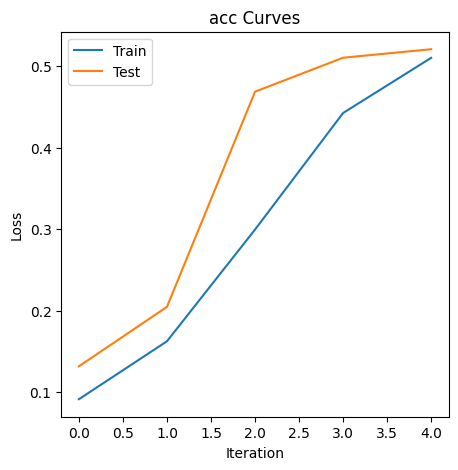

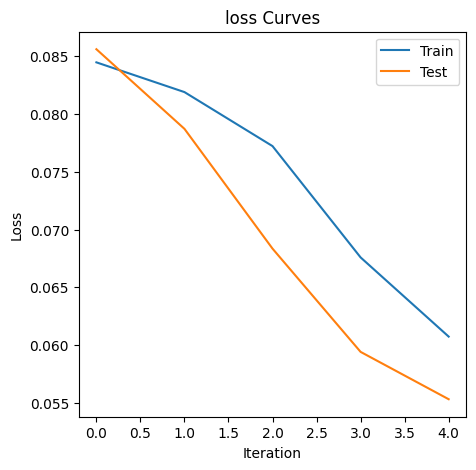

In [15]:
plot_data(train_accs,test_accs,"acc")
plot_data(train_losss,test_losss,"loss")

##### MNIST

In [ ]:
# 数据集获取
def get_mnist(data_path, batch_size):
    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28, 28)),
    #             transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))
                ])

    mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
    mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader,test_loader

In [30]:
root_dir = r'../data'
batch_size=512
lr=1e-2
weight_decay = 1e-5
warmup = True
num_epochs = 5
warmup_epochs = 2
num_classes = 10
data_type = 0  # 数据是否具有时间维度，0表示没有，1表示有
T = 4 # 静态数据需要的时间步
if_lrsche = 1
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了,一般会在网络中直接加入时间步，所以基本上这个值都是0

transform = transforms.Compose([
            transforms.Resize((28, 28)),
#             transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
            ])
mnist_train = datasets.MNIST(root_dir, train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(root_dir, train=False, download=False, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 1,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
loss_function = F.mse_loss
# scaler = None
scaler = amp.GradScaler()
train_accs = []
train_losss = []
test_accs = []
test_losss = []

In [31]:
train_accs,train_losss,test_accs,test_losss = train(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_mnist.pt", if_lrsche = if_lrsche)

  0%|          | 0/117 [00:00<?, ?it/s]

epoch = 0,current_lr  = 1e-05
train_single_time = 17.9990
loss = 0.1407
acc = 18.70%


  0%|          | 0/19 [00:00<?, ?it/s]

test All Acc: 30.04%
test All Loss: 0.10
save model param
escape time = 2024-09-29 18:30:14





  0%|          | 0/117 [00:00<?, ?it/s]

epoch = 1,current_lr  = 5.26923076923077e-05
train_single_time = 17.5746
loss = 0.0743
acc = 56.56%


  0%|          | 0/19 [00:00<?, ?it/s]

test All Acc: 71.18%
test All Loss: 0.06
save model param
escape time = 2024-09-29 18:30:10





  0%|          | 0/117 [00:00<?, ?it/s]

epoch = 2,current_lr  = 9.53846153846154e-05
train_single_time = 16.9943
loss = 0.0470
acc = 80.87%


  0%|          | 0/19 [00:00<?, ?it/s]

test All Acc: 87.48%
test All Loss: 0.04
save model param
escape time = 2024-09-29 18:30:08





  0%|          | 0/117 [00:00<?, ?it/s]

epoch = 3,current_lr  = 0.00013807692307692308
train_single_time = 17.6207
loss = 0.0293
acc = 90.75%


  0%|          | 0/19 [00:00<?, ?it/s]

test All Acc: 93.39%
test All Loss: 0.02
save model param
escape time = 2024-09-29 18:30:10





  0%|          | 0/117 [00:00<?, ?it/s]

epoch = 4,current_lr  = 0.00018076923076923077
train_single_time = 18.2087
loss = 0.0196
acc = 94.44%


  0%|          | 0/19 [00:00<?, ?it/s]

test All Acc: 95.75%
test All Loss: 0.02
save model param
escape time = 2024-09-29 18:30:11





##### NMNIST 

------------------探索----------------------

In [18]:
import tonic
import torch
# from tqdm import tqdm
from tqdm.notebook import tqdm  
import torchvision
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

1.2快速数据加载  
  
原始数据以一种读取速度较慢的格式存储。为了加速数据加载，我们可以利用磁盘缓存和批处理。这意味着一旦从原始数据集中加载文件，它们就会被写入磁盘。  因为事件记录具有不同的长度，我们将提供一个排序函数tonic.collation.PadTensors()，该函数将填充较短的记录，以确保批处理中的所有样本具有相同的尺寸。

In [24]:
sensor_size = tonic.datasets.NMNIST.sensor_size

frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, 
                                                         time_window=10000)
                                     ])
trainset = tonic.datasets.NMNIST(save_to='../data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='../data', transform=frame_transform, train=False)

# transform = tonic.transforms.Compose([torch.from_numpy,
#                                       torchvision.transforms.RandomRotation([-10,10])])

# cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='../data/nmnist_local/train')
# # no augmentations for the testset
# cached_testset = DiskCachedDataset(testset, cache_path='../data/nmnist_local/test')

# batch_size = 10
# trainloader = DataLoader(cached_trainset, batch_size=batch_size, 
#                          collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False,drop_last=True)
# testloader = DataLoader(cached_testset, batch_size=batch_size, 
#                         collate_fn=tonic.collation.PadTensors(batch_first=False), drop_last=True)

In [13]:
for event_tensor, target in tqdm(trainloader):
    print(event_tensor.shape)
    break

  0%|          | 0/6000 [00:00<?, ?it/s]

torch.Size([309, 10, 2, 34, 34])


In [27]:
sensor_size
trainset[4][0].shape

(30, 2, 34, 34)

----------------------结束----------------------------------------------

##### NMNIST数据集

In [7]:
from start1 import *

In [ ]:
## 数据划分方式
# from spikingjelly.datasets.n_mnist import NMNIST

# data_path = r'E:\mycode\jupyter\0.SNN\data\NMNIST'
# T = 20
# train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
# test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')

In [8]:
# 数据集获取   NMNIST
def get_nmnist(data_path = r'../data/NMNIST', batch_size = 512, T = 20):
    train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
    test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [10]:
train_loader,test_loader = get_nmnist()
len(train_loader)
len(test_loader)

The directory [../data/NMNIST\frames_number_20_split_by_number] already exists.
The directory [../data/NMNIST\frames_number_20_split_by_number] already exists.


117

19

##### ASLDVS数据集   
无法使用

In [18]:
# from spikingjelly.datasets.asl_dvs import ASLDVS

In [19]:
# data_path = r'../data/ASLDVS'
# T = 20
# train_set = ASLDVS(root=data_path, data_type='frame', frames_number=T, split_by='number')

The [../data/ASLDVS\download] directory for saving downloaded files already exists, check files...
The ICCV2019_DVS_dataset.zip is packed by dropbox. We find that the MD5 of this zip file can change. So, MD5 check will not be used for this ASL-DVS dataset.
The file [../data/ASLDVS\download\ICCV2019_DVS_dataset.zip] does not exist or is corrupted.


NotImplementedError: This dataset can not be downloaded by SpikingJelly, please download [ICCV2019_DVS_dataset.zip] from [https://www.dropbox.com/sh/ibq0jsicatn7l6r/AACNrNELV56rs1YInMWUs9CAa?dl=0] manually and put files at ../data/ASLDVS\download.

##### NCaltech101数据集  
这个数据集没有自动划分好训练集，测试集，所以需要自己手动划分

In [22]:
from spikingjelly.datasets.n_caltech101 import NCaltech101
import torch
from spikingjelly.datasets import split_to_train_test_set as sptt

In [ ]:
# from spikingjelly.datasets.n_caltech101 import NCaltech101
# import torch
# from spikingjelly.datasets import split_to_train_test_set as sptt

# data_path = r'E:\mycode\jupyter\0.SNN\data\NCaltech101'
# T = 20
# num_classes = 101
# data = NCaltech101(root=data_path, data_type='frame', frames_number=T, split_by='number')

# train_set, test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split =True)
# torch.save(train_set, r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_train0.8.pth')
# torch.save(test_set, r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_test0.2.pth')
# train_data = torch.load(r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_train0.8.pth')
# test_set = torch.load(r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_test0.2.pth')
# print(train_data)

In [18]:
# data_path = r'../data/NCaltech101'
# T = 20
# num_classes = 101
# data = NCaltech101(root=data_path, data_type='frame', frames_number=T, split_by='number')

# train_set,test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split =True)
# torch.save(train_set,r'../data/cifar10dvs_split/NCaltech101_train0.8.pth')
# torch.save(test_set,r'../data/cifar10dvs_split/NCaltech101_test0.2.pth')
# train_data = torch.load(r'../data/cifar10dvs_split/cifar_train0.7.pth')
# test_set = torch.load(r'../data/cifar10dvs_split/cifar_test0.3.pth')

The [../data/NCaltech101\download] directory for saving downloaded files already exists, check files...
Mkdir [../data/NCaltech101\extract].
Extract [../data/NCaltech101\download\Caltech101.zip] to [../data/NCaltech101\extract].


KeyboardInterrupt: 

In [27]:
# from spikingjelly.datasets.n_caltech101 import NCaltech101
# import torch
# from spikingjelly.datasets import split_to_train_test_set as sptt

# data_path = r'E:\mycode\jupyter\0.SNN\data\NCaltech101'
# T = 20
# num_classes = 101
# data = NCaltech101(root=data_path, data_type='frame', frames_number=T, split_by='number')

# train_set, test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split =True)
# torch.save(train_set, r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_train0.8.pth')
# torch.save(test_set, r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_test0.2.pth')
# train_data = torch.load(r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_train0.8.pth')
# test_data = torch.load(r'E:\mycode\jupyter\0.SNN\data\NCaltech101\NCaltech101_split\NCaltech101_test0.2.pth')
# len(train_data)
# len(test_data)

The directory [E:\mycode\jupyter\0.SNN\data\NCaltech101\frames_number_20_split_by_number] already exists.


100%|██████████████████████████████████████████████████████████████████████████████| 8709/8709 [07:42<00:00, 18.85it/s]
C:\Users\ALiang\AppData\Local\Temp\ipykernel_16080\3129222799.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

7008

1701

In [16]:
# 数据集获取  NCaltech101
def get_NCaltech101(train_path = r'../data/NCaltech101/split/t20/train0.8.pth', 
                   test_path = r'../data/NCaltech101/split/t20/test0.2.pth',
                   batch_size = 64, T = 20):
    train_set = torch.load(train_path)
    test_set = torch.load(test_path)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [17]:
train_loader,test_loader = get_NCaltech101()
len(train_loader)
len(test_loader)

C:\Users\ALiang\AppData\Local\Temp\ipykernel_17412\2771308110.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load(train_path)
C:\Users\ALiang\AppData\

109

26

##### Cifar10 数据集

In [1]:
from start1 import *

In [3]:
# 数据集获取
def get_cifar10(data_path, batch_size):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

    return train_loader,test_loader

##### 测试学习率的调度

<Figure size 600x300 with 0 Axes>

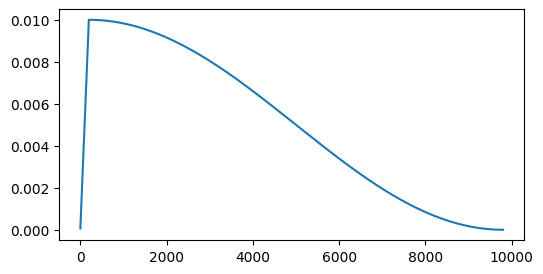

In [25]:
root_dir = r'../data'
batch_size=512
lr=1e-2
weight_decay = 0.
warmup = True
num_epochs = 100
warmup_epochs = 2
num_classes = 10
T = 0
train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
lr_list =[]
# 绘制学习率
for _ in range(num_epochs):
    for _ in range(len(train_loader)):
        lr_scheduler.step()
        lr = optimizer.param_groups[0]["lr"]
        lr_list.append(lr)

plt.figure(figsize = (6,3))
plt.plot(range(len(lr_list)),lr_list)
plt.show()

<Figure size 600x300 with 0 Axes>

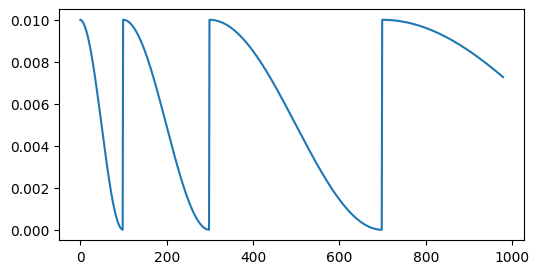

In [35]:
root_dir = r'../data'
batch_size=512
lr=1e-2
weight_decay = 0.
warmup = True
num_epochs = 10
warmup_epochs = 2
num_classes = 10
T = 0
train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2)
lr_list =[]
# 绘制学习率
for _ in range(num_epochs):
    for _ in range(len(train_loader)):
        lr_scheduler.step()
        # 下面这两种获取学习率的方式一样
#         lr = optimizer.param_groups[0]["lr"]
        lr = lr_scheduler.get_last_lr()[0]
        lr_list.append(lr)

plt.figure(figsize = (6,3))
plt.plot(range(len(lr_list)),lr_list)
plt.show()

当使用 CosineAnnealingLR 或者 StepLR 阶跃函数时，我们不需要在train_loader内部使用lr_scheduler.step()，只在epoch迭代时使用

<Figure size 600x300 with 0 Axes>

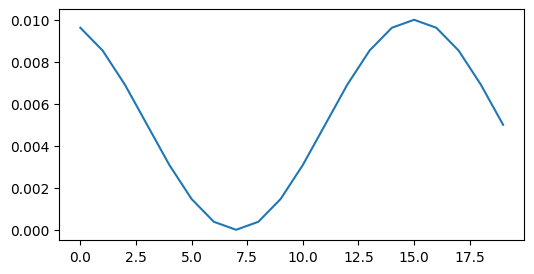

In [39]:
root_dir = r'../data'
batch_size=512
lr=1e-2
weight_decay = 0.
warmup = True
num_epochs = 20
warmup_epochs = 2
num_classes = 10
T = 0
train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
# T_max默认设置成和num_epochs一样，小于epochs会导致学习率回升。
lr_scheduler = CosineAnnealingLR(optimizer, T_max=8)
lr_list =[]
# 绘制学习率，注意哦
for _ in range(num_epochs):
#     for _ in range(len(train_loader)):
    lr_scheduler.step()
    lr = optimizer.param_groups[0]["lr"]
    lr_list.append(lr)

plt.figure(figsize = (6,3))
plt.plot(range(len(lr_list)),lr_list)
plt.show()

##### 进行训练

In [1]:
from start1 import *

# 数据集获取
def get_cifar10(data_path, batch_size):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

    return train_loader,test_loader

In [4]:
root_dir = r'../data'
batch_size=512
lr=1e-2
weight_decay = 0.
warmup = True
num_epochs = 20
warmup_epochs = 5
num_classes = 10
data_type = 0  # 数据是否具有时间维度，0表示没有，1表示有
T = 4 # 静态数据需要的时间步
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了,一般会在网络中直接加入时间步，所以基本上这个值都是0

train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
loss_function = F.mse_loss
# scaler = None
scaler = amp.GradScaler()

In [5]:
train_accs,train_losss,test_accs,test_losss = trains(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_cifar10.pt", lr_scheduler = lr_scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 0, current_lr = 0.2008
train_single_time = 8.0244
loss = 0.4407
acc = 9.59%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 10.00%
test All Loss: 19.44
save model param
escape time = 2024-10-05 17:51:32





  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 1, current_lr = 0.4006
train_single_time = 7.0893
loss = 0.1171
acc = 10.28%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 10.05%
test All Loss: 2.18
save model param
escape time = 2024-10-05 17:51:07





  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 2, current_lr = 0.6003999999999999
train_single_time = 7.1748
loss = 0.0957
acc = 10.85%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 9.31%
test All Loss: 0.35
escape time = 2024-10-05 17:51:14





  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 3, current_lr = 0.8002
train_single_time = 7.0429
loss = 0.1166
acc = 11.52%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 12.41%
test All Loss: 0.21
save model param
escape time = 2024-10-05 17:51:15





  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 4, current_lr = 1.0
train_single_time = 7.4471
loss = 0.1459
acc = 12.56%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 9.99%
test All Loss: 0.77
escape time = 2024-10-05 17:51:16





  0%|          | 0/20 [00:00<?, ?it/s]

epoch = 5, current_lr = 0.9890738112931025
train_single_time = 7.5347
loss = 0.9937
acc = 10.94%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 10.00%
test All Loss: 1209.59
escape time = 2024-10-05 17:51:23





  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

#####  cifar10DVS数据集

In [12]:
from start1 import *

In [37]:
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
import torch
from spikingjelly.datasets import split_to_train_test_set as sptt

data_path = r'../data/CIFAR10DVS'
T = 20
num_classes = 10
data = CIFAR10DVS(root = data_path, data_type='frame', frames_number=T, split_by='number')
data.root = '../data/CIFAR10DVS/frames_number_20_split_by_number'
print(data)

train_set, test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split = False)
torch.save(train_set, r'../data/CIFAR10DVS/split/t20/train0.8.pth')
torch.save(test_set, r'../data/CIFAR10DVS/split/t20/test0.2.pth')
train_data = torch.load(r'../data/CIFAR10DVS/split/t20/train0.8.pth')
test_data = torch.load(r'../data/CIFAR10DVS/split/t20/test0.2.pth')
len(train_data)
len(test_data)

The directory [../data/CIFAR10DVS\frames_number_20_split_by_number] already exists.


Dataset CIFAR10DVS
    Number of datapoints: 10000
    Root location: ../data/CIFAR10DVS/frames_number_20_split_by_number

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:01<00:00, 27.66it/s]
C:\Users\ALiang\AppData\Local\Temp\ipykernel_15068\1049863804.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

8000

2000

In [16]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
for x,y in train_loader:
    print(x.shape, y.shape)
    
    break

torch.Size([16, 20, 2, 128, 128]) torch.Size([16])


In [38]:
data

Dataset CIFAR10DVS
    Number of datapoints: 10000
    Root location: ../data/CIFAR10DVS/frames_number_20_split_by_number

In [17]:
# from start1 import *
# num_classes = 10
# label_idx = []
# for i in range(num_classes):
#     label_idx.append([])
# for index,(i,j) in tqdm(enumerate(train_set)):
#     label_idx[j].append(index) 

0it [00:00, ?it/s]

In [20]:
# for i in label_idx:
#     print(len(i), i[0])

800 0
800 800
800 1600
800 2400
800 3200
800 4000
800 4800
800 5600
800 6400
800 7200


In [75]:
root_dir = r'../data/CIFAR10DVS'
T = 5 # 对于非DVS执行的时间步，该数据集在划分的时候默认为5
batch_size=64
lr=1e-2
weight_decay = 1e-5
warmup = True
num_epochs = 5
warmup_epochs = 2
num_classes = 10
inp_channels = 2  # DVS系列的数据集貌似都是2
data_type = 1 # 0表示数据没有时间维度，1表示数据有时间维度
if_lrsche = 1
T_data = 0 # 该参数轻易不用

# data = CIFAR10DVS(root = root_dir, data_type='frame', frames_number=T, split_by='number')
# train_set,test_set = sptt(train_ratio = 0.7,origin_dataset = data,num_classes = num_classes,random_split = False)
train_set = torch.load(r'../data/cifar10dvs_split/cifar_train0.7.pth')
test_set = torch.load(r'../data/cifar10dvs_split/cifar_test0.3.pth')

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = inp_channels,num_classes = num_classes, connect_f = 'ADD',T = T, data_type = data_type).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
loss_function = F.mse_loss
# scaler = None
scaler = amp.GradScaler()
train_accs = []
train_losss = []
test_accs = []
test_losss = []

C:\Users\ALiang\AppData\Local\Temp\ipykernel_18756\1567968446.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load(r'../data/cifar10dvs_split/cifar_tr

In [74]:
# # 保存训练集和验证集 
# torch.save(train_set, r'../data/cifar10dvs_split/cifar_train0.7.pth')
# torch.save(test_set, r'../data/cifar10dvs_split/cifar_test0.3.pth')

# # 加载数据集
# train_set1 = torch.load(r'../data/cifar10dvs_split/cifar_train0.7.pth')
# test_set1 = torch.load(r'../data/cifar10dvs_split/cifar_test0.3.pth')
# print(f"训练集大小: {len(train_set1)}")
# print(f"验证集大小: {len(test_set1)}")

训练集大小: 7000
验证集大小: 3000


C:\Users\ALiang\AppData\Local\Temp\ipykernel_18756\2847351000.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set1 = torch.load(r'../data/cifar10dvs_split/cifar_tr

In [68]:
train_accs,train_losss,test_accs,test_losss = train(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_cifar10DVS.pt", if_lrsche = if_lrsche)

  0%|          | 0/109 [00:00<?, ?it/s]

epoch = 0,current_lr  = 1e-05
train_single_time = 56.2050
loss = 0.0957
acc = 12.87%


  0%|          | 0/46 [00:00<?, ?it/s]

test All Acc: 16.92%
test All Loss: 0.09
save model param
escape time = 2024-09-29 20:22:45





  0%|          | 0/109 [00:00<?, ?it/s]

epoch = 1,current_lr  = 5.58256880733945e-05
train_single_time = 55.2066
loss = 0.0857
acc = 23.42%


  0%|          | 0/46 [00:00<?, ?it/s]

test All Acc: 26.26%
test All Loss: 0.08
save model param
escape time = 2024-09-29 20:22:42





  0%|          | 0/109 [00:00<?, ?it/s]

epoch = 2,current_lr  = 0.00010165137614678899
train_single_time = 55.3194
loss = 0.0827
acc = 30.75%


  0%|          | 0/46 [00:00<?, ?it/s]

test All Acc: 30.30%
test All Loss: 0.08
save model param
escape time = 2024-09-29 20:22:42





  0%|          | 0/109 [00:00<?, ?it/s]

epoch = 3,current_lr  = 0.0001474770642201835
train_single_time = 59.9505
loss = 0.0798
acc = 35.75%


  0%|          | 0/46 [00:00<?, ?it/s]

test All Acc: 27.58%
test All Loss: 0.09
escape time = 2024-09-29 20:22:56





  0%|          | 0/109 [00:00<?, ?it/s]

epoch = 4,current_lr  = 0.00019330275229357798
train_single_time = 56.4581
loss = 0.0777
acc = 39.84%


  0%|          | 0/46 [00:00<?, ?it/s]

test All Acc: 34.54%
test All Loss: 0.08
save model param
escape time = 2024-09-29 20:22:53





#####  cifar100数据集

In [12]:
# 数据集获取
def get_cifar100(data_path, batch_size):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR100(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR100(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

    return train_loader,test_loader

In [54]:
root_dir = r'../data'
batch_size=512
lr = 1e-2
weight_decay = 0
warmup = True
num_epochs = 5
warmup_epochs = 1
num_classes = 100
data_type = 0  # 数据是否具有时间维度，0表示没有，1表示有
T = 4 # 静态数据需要的时间步
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了,一般会在网络中直接加入时间步，所以基本上这个值都是0

train_loader,test_loader = get_cifar100(data_path = root_dir, batch_size = batch_size)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T, data_type = data_type).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
# lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
#                                    warmup=warmup, warmup_epochs=warmup_epochs)
# loss_function = F.mse_loss
loss_function = nn.CrossEntropyLoss()
# scaler = None
scaler = amp.GradScaler()
train_accs = []
train_losss = []
test_accs = []
test_losss = []

In [55]:
train_accs,train_losss,test_accs,test_losss = train(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_cifar100.pt", lr_scheduler = None)

  0%|          | 0/98 [00:00<?, ?it/s]

epoch = 0,current_lr  = 0.01
train_single_time = 18.3328
loss = 4.0055
acc = 8.19%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 12.47%
test All Loss: 3.67
save model param
escape time = 2024-09-29 21:12:56





  0%|          | 0/98 [00:00<?, ?it/s]

epoch = 1,current_lr  = 0.01
train_single_time = 17.5758
loss = 3.3549
acc = 17.94%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 19.49%
test All Loss: 3.30
save model param
escape time = 2024-09-29 21:12:53





  0%|          | 0/98 [00:00<?, ?it/s]

epoch = 2,current_lr  = 0.01
train_single_time = 17.0364
loss = 2.9894
acc = 24.72%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 24.04%
test All Loss: 3.08
save model param
escape time = 2024-09-29 21:12:52





  0%|          | 0/98 [00:00<?, ?it/s]

epoch = 3,current_lr  = 0.01
train_single_time = 17.1835
loss = 2.7262
acc = 30.13%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 29.33%
test All Loss: 2.85
save model param
escape time = 2024-09-29 21:12:52





  0%|          | 0/98 [00:00<?, ?it/s]

epoch = 4,current_lr  = 0.01
train_single_time = 17.3954
loss = 2.4996
acc = 35.01%


  0%|          | 0/20 [00:00<?, ?it/s]

test All Acc: 33.36%
test All Loss: 2.63
save model param
escape time = 2024-09-29 21:12:52





##### ImageNet数据集

In [10]:
def get_imagenet(data_path, batch_size):
    
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                    shuffle=True,pin_memory=True, drop_last = True, persistent_workers = True, num_workers = 8)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                    shuffle=False,pin_memory=True, drop_last = True, persistent_workers = True, num_workers = 8)
    return train_loader,val_loader

In [11]:
root_dir = r'../data/Imagenet2012/imagenet'
batch_size=32
lr = 1e-2
weight_decay = 0
warmup = True
num_epochs = 5
warmup_epochs = 1
num_classes = 1000
input_channels = 3
data_type = 0  # 数据是否具有时间维度，0表示没有，1表示有
T = 4 # 静态数据需要的时间步
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了,一般会在网络中直接加入时间步，所以基本上这个值都是0

train_loader,test_loader = get_imagenet(data_path = root_dir, batch_size = batch_size)

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = input_channels,num_classes = num_classes, connect_f = 'ADD',T = T, data_type = data_type).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
# lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
#                                    warmup=warmup, warmup_epochs=warmup_epochs)
# loss_function = F.mse_loss
loss_function = nn.CrossEntropyLoss()
# scaler = None
scaler = amp.GradScaler()
train_accs = []
train_losss = []
test_accs = []
test_losss = []

In [12]:
train_accs,train_losss,test_accs,test_losss = train(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_imagenet.pt", lr_scheduler = None)

  0%|          | 0/40036 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()  # 强制进行一次垃圾回收

1711

### 将网络，训练函数，测试函数进行打包处理,使用时运行下面的函数即可训练

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# # InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
import gc,math,torch,os,sys,time,datetime
from spikingjelly.activation_based import surrogate
from spikingjelly.activation_based import encoding
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from tqdm import tqdm
from tqdm.notebook import tqdm  # tqdm 进度条显示,这个更好看
from spikingjelly.activation_based import monitor, neuron, functional, layer
import numpy as np
from torch import amp,optim # 自动微分
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets import split_to_train_test_set as sptt
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer


In [3]:
def plot_data(train_data,test_data,name):
    # Plot Loss
    fig = plt.figure(facecolor="w", figsize=(5, 5))
    plt.plot(train_data)
    plt.plot(test_data)
    plt.title(name+" Curves")
    plt.legend(["Train", "Test"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

In [4]:
# 学习率调度函数
def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=1e-3,
                        end_factor=1e-6):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        """
        根据step数返回一个学习率倍率因子， 这个倍率因子乘以学习率等于我们最终使用的lr
        注意在训练开始之前，pytorch会提前调用一次lr_scheduler.step()方法
        """
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            # warmup过程中lr倍率因子从warmup_factor -> 1
            return warmup_factor * (1 - alpha) + alpha
        else:
            current_step = (x - warmup_epochs * num_step)
            cosine_steps = (epochs - warmup_epochs) * num_step
            # warmup后lr倍率因子从1 -> end_factor
            return ((1 + math.cos(current_step * math.pi / cosine_steps)) / 2) * (1 - end_factor) + end_factor

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)

# 权重分配函数
def get_params_groups(model: torch.nn.Module, weight_decay: float = 1e-5):
    # 记录optimize要训练的权重参数
    parameter_group_vars = {"decay": {"params": [], "weight_decay": weight_decay},
                            "no_decay": {"params": [], "weight_decay": 0.}}

    # 记录对应的权重名称
    parameter_group_names = {"decay": {"params": [], "weight_decay": weight_decay},
                             "no_decay": {"params": [], "weight_decay": 0.}}

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights

        if len(param.shape) == 1 or name.endswith(".bias"):
            group_name = "no_decay"
        else:
            group_name = "decay"

        parameter_group_vars[group_name]["params"].append(param)
        parameter_group_names[group_name]["params"].append(name)

#     print("Param groups = %s" % json.dumps(parameter_group_names, indent=2))
    return list(parameter_group_vars.values())

In [5]:
def train(num_epochs, net, train_loader,test_loader, optimizer, device, loss_function, best_acc = 0, 
          scaler = None, encoder = encoding.PoissonEncoder(), T = 0, num_classes = 10, data_type = 0, save_model = "",
          lr_scheduler = None):
    '''
    data_type: 数据维度是否具有时间维度，0表示没有，1表示有
    T != 0 ,代表需要encoder了，且是在网络外进行的时间步循环
    '''
    loss_MSE = F.mse_loss
    for epoch in range(num_epochs):
        start_time = time.time()
        _ = net.train()
        train_loss = 0
        train_acc = 0
        train_samples = 0

        datas = tqdm(iter(train_loader),file=sys.stdout)
        for img, label in datas:
            # 梯度清零
            optimizer.zero_grad()
            img = img.to(device)
            if data_type != 0:
                img = img.transpose(0, 1)  # 将数据维度由  [N, T, C, H, W] 变为  [T, N, C, H, W]
            label = label.to(device)
            label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码

            # 混合精度训练
            if scaler is not None:
                with amp.autocast(str(device)):
#                 with amp.autocast():
                    out_fr = 0.
                    if T != 0:
                        for _ in range(T):
                            encoded_img = encoder(data)
                            out_fr += net(encoded_img) # 将每次输出的脉冲进行相加
                        out_fr = out_fr / T # 求平均值
                    else:
#                         print(img.type())
                        out_fr = net(img)
                    if loss_function == loss_MSE:
                        loss = F.mse_loss(out_fr, label_onehot)
                    else:
                        loss = loss_function(out_fr, label)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                out_fr = 0.
                if T != 0:
                    for _ in range(T):
                        encoded_img = encoder(data)
                        out_fr += net(encoded_img) # 将每次输出的脉冲进行相加
                    out_fr = out_fr / T # 求平均值
                else:
                    out_fr = net(img)
#                 print(out_fr.shape,label_onehot.shape)
                if loss_function == loss_MSE:
                    loss = F.mse_loss(out_fr, label_onehot)
                else:
                    loss = loss_function(out_fr, label)
                loss.backward()
                optimizer.step()

            train_samples += label.numel()
            train_loss += loss.item() * label.numel()
            # 正确率的计算方法如下。  认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            train_acc += (out_fr.argmax(1) == label).float().sum().item()
            # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的。
            functional.reset_net(net)
#         current_lr = lr_scheduler.get_last_lr()[0] 
        current_lr = optimizer.param_groups[0]['lr']
        if lr_scheduler != None:
            lr_scheduler.step() # 学习率的优化
        end_time = time.time()
        print(f"epoch = {epoch},current_lr  = {current_lr}")
        print(f"train_single_time = {end_time - start_time:.4f}")
        print(f"loss = {train_loss/train_samples:.4f}")
        print(f"acc = {train_acc/train_samples*100:.2f}%")
        train_accs.append(train_acc/train_samples)
        train_losss.append(train_loss/train_samples)

        test_acc,test_loss = evaluates("test", net, test_loader,device,loss_function, encoder = encoding.PoissonEncoder(),
                                       T = T, num_classes = num_classes, data_type = data_type)
        test_accs.append(test_acc)
        test_losss.append(test_loss)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(net.state_dict(), save_model)
            print("save model param")
        print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (num_epochs - epoch - 1))).strftime("%Y-%m-%d %H:%M:%S")}\n')
        print("\n") 
    return train_accs,train_losss,test_accs,test_losss

In [6]:
def evaluates(name, model, data_loader, device,loss_function, encoder = encoding.PoissonEncoder(), T = 0, num_classes = 10, data_type = 0):
    """
    T = 0，代表具有网络的输出已经在时间维度上进行了平均 ------ T != 0，表示网络没有时间维度这个概念，这种情况下一般需要先编码，最后平均。
    data_type代表的是数据类型，0代表正常数据集，1代表具有时间维度的数据集。
    这个测试函数仅适用于使用独热编码的mse损失函数。
    """
    loss_MSE = F.mse_loss
    acc = 0
    losss = 0
    data_num = 0
    _ = model.eval()

    datas = tqdm(iter(data_loader),file=sys.stdout)
    with torch.no_grad():
        for data, label in datas:
            data = data.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, num_classes).float()  # 将标签变为独热编码
            if data_type != 0:
                data = data.transpose(0, 1)
            
            out_fr = 0.
            if T == 0:
                out_fr = model(data)
            else:
                for _ in range(T):
                    encoded_img = encoder(data)
                    out_fr += model(encoded_img) # 将每次输出的脉冲进行相加
                out_fr = out_fr / T # 求平均值
            
            if loss_function == loss_MSE:
                loss = F.mse_loss(out_fr, label_onehot)
            else:
                loss = loss_function(out_fr, label)
            data_num += label.numel()
            losss += loss.item() * label.numel()
            # 正确率的计算方法如下。认为输出层中脉冲发放频率最大的神经元的下标i是分类结果
            acc += (out_fr.argmax(1) == label).float().sum().item()
            
            # 每次重置网络
            functional.reset_net(model)
    
    print(f"{name} All Acc: {acc/data_num * 100:.2f}%")
    print(f"{name} All Loss: {losss/data_num:.2f}")
    return acc/data_num,losss/data_num

In [7]:
class DVSGestureNet(nn.Module):
    def __init__(self, inp_channels = 3, num_classes = 11, channels=128):
        super().__init__()
        conv = []
        for i in range(5):
            if conv.__len__() == 0:
                in_channels = inp_channels
            else:
                in_channels = channels

            conv.append(layer.Conv2d(in_channels, channels, kernel_size=3, padding=1, bias=False))
            conv.append(layer.BatchNorm2d(channels))
            conv.append(neuron.IFNode(surrogate_function=surrogate.ATan()))
#             neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan())   两种神经元的替换使用
            conv.append(layer.MaxPool2d(2, 2))
        

        self.conv_fc = nn.Sequential(
            *conv,
            layer.Flatten(),
            layer.Dropout(0.5),
            layer.Linear(channels * 4 * 4, 512),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Dropout(0.5),
            layer.Linear(512, 110),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.VotingLayer(int(110 / num_classes))
        )
        # 设置网络的模式，是单步还是多步，一般都是多步
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        output = self.conv_fc(x)
        return output.mean(dim=0)

In [8]:
# SEW_ResNet原始网络及面对不同数据集所进行的网络变换以及数据操作的变换
class BasicBlock(nn.Module):
    """
    实现ResNet网络的第一个基础架构
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(BasicBlock, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('SpikingBasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in SpikingBasicBlock")

        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=False),
            norm_layer(planes),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False),
            norm_layer(planes),
            neuron.IFNode(surrogate_function=surrogate.ATan()))

        self.downsample = downsample
        
        # 设置所有的层为多步模式
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
#         print(out.shape)
#         print(identity.shape)
        if self.connect_f == 'ADD':
            out += identity
        elif self.connect_f == 'AND':
            out *= identity
        elif self.connect_f == 'IAND':
            out = identity * (1. - out)
        else:
            raise NotImplementedError(self.connect_f)

        return out


class Bottleneck(nn.Module):
    """
    实现ResNet网络的瓶颈架构
    """
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(Bottleneck, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, width, kernel_size=1, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, groups = groups, dilation = dilation, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer3 = nn.Sequential(
            layer.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False),
            norm_layer(planes * self.expansion),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
   
        self.downsample = downsample
        
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        if self.connect_f == 'ADD':
            out += identity
        elif self.connect_f == 'AND':
            out *= identity
        elif self.connect_f == 'IAND':
            out = identity * (1. - out)
        else:
            raise NotImplementedError(self.connect_f)

        return out

# 对这两个架构的最后一层中的 BN 层进行设置，权重为0，且当连接方式为AND时，偏差置为1
def zero_init_blocks(net: nn.Module, connect_f: str):
    for m in net.modules():
        if isinstance(m, Bottleneck):
            nn.init.constant_(m.layer3.module[1].weight, 0)
            if connect_f == 'AND':
                nn.init.constant_(m.layer3.module[1].bias, 1)
        elif isinstance(m, BasicBlock):
            nn.init.constant_(m.layer2.module[1].weight, 0)
            if connect_f == 'AND':
                nn.init.constant_(m.layer2.module[1].bias, 1)
        else:
            pass

# 设计SEWResNet网络，原始的网络
class SEWResNet(nn.Module):

    def __init__(self, block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, T=4, connect_f=None, drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0):
        """
        data_type：输入的数据是没有时间维度的，还是具有时间维度的
        net_type：使用sew_resnet还是sew_resnet2
        """
        super(SEWResNet, self).__init__()
        
        # 是否使用扩张率代替步长，一般这个操作应该用不上
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.T = T
        self.connect_f = connect_f
        self.groups = groups
        self.base_width = width_per_group
        self.drops = drops
        self.data_type = data_type
        self.net_type = net_type
        
        self.layer01 = nn.Sequential(
            layer.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            norm_layer(self.inplanes))
        
        self.layer01s = nn.Sequential(
            layer.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            norm_layer(self.inplanes))
        functional.set_step_mode(self.layer01s, step_mode='m')
        
        self.layer02 = nn.Sequential(
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=3, stride=2, padding=1))
        functional.set_step_mode(self.layer02, step_mode='m')

        self.layer1 = self._make_layer(block, 64, layers[0], connect_f=connect_f)
        self.dp1 = layer.Dropout(p[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0], connect_f=connect_f)
        self.dp2 = layer.Dropout(p[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1], connect_f=connect_f)
        self.dp3 = layer.Dropout(p[2])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2], connect_f=connect_f)
        self.dp4 = layer.Dropout(p[3])
        self.avgpool = layer.AdaptiveAvgPool2d((1, 1))
        # 最后一层的通道输出需要乘以扩张率
        self.fc = layer.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, layer.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (layer.BatchNorm2d, layer.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            zero_init_blocks(self, connect_f)
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, connect_f=None):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        # 使用扩张率代替步长
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # 步长不等于1的时候，当然我们需要使用下采样层，当步长为1，但是在一个Block中，输入通道数不等于输出通道数的时候，
        # 我们仍然需要使用下采样层，因为我们每一个block块的输出一定是 planes * block.expansion，输入一定是self.inplanes
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    layer.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride = stride, bias=False),
                    norm_layer(planes * block.expansion),
                    neuron.IFNode(surrogate_function=surrogate.ATan()))
            functional.set_step_mode(downsample, step_mode='m')
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, connect_f))
        # 注意经过一个block之后，输入会发生通道的变化。
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, connect_f=connect_f))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        if self.data_type == 0:
            if self.net_type == 0:
                x = self.layer01(x)
                x.unsqueeze_(0) # 这一步经过实验可以去掉，因为x.repeat会自动添加维度
                x = x.repeat(self.T, 1, 1, 1, 1)  # T,B,C,H,W
            else:
                x.unsqueeze_(0) # 这一步经过实验可以去掉，因为x.repeat会自动添加维度
                x = x.repeat(self.T, 1, 1, 1, 1)  # T,B,C,H,W
                x = self.layer01s(x)
        else:
            x = self.layer01s(x)
        x = self.layer02(x)
        x = self.layer1(x)
        if self.drops[0]:
            x = self.dp1(x)
        x = self.layer2(x)
        if self.drops[1]:
            x = self.dp2(x)
        x = self.layer3(x)
        if self.drops[2]:
            x = self.dp3(x)
        x = self.layer4(x)
        if self.drops[3]:
            x = self.dp4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 2) # 将C,H,W合并为一体
        return self.fc(x.mean(dim=0)) # 首先在T这个维度求平均，接着使用Linear层

    def forward(self, x):
        return self._forward_impl(x)
    
def _sew_resnet(block, layers, **kwargs):
    model = SEWResNet(block, layers, **kwargs)
    return model


def sew_resnet18(**kwargs):
    return _sew_resnet(BasicBlock, [2, 2, 2, 2], **kwargs)


def sew_resnet34(**kwargs):
    return _sew_resnet(BasicBlock, [3, 4, 6, 3], **kwargs)


def sew_resnet50(**kwargs):
    return _sew_resnet(Bottleneck, [3, 4, 6, 3], **kwargs)


def sew_resnet101(**kwargs):
    return _sew_resnet(Bottleneck, [3, 4, 23, 3], **kwargs)


def sew_resnet152(**kwargs):
    return _sew_resnet(Bottleneck, [3, 8, 36, 3], **kwargs)

spiking_resnet

In [9]:
# spiking_resnet网络的实现
class SP_BasicBlock(nn.Module):
    """
    实现ResNet网络的第一个基础架构
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(SP_BasicBlock, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('SpikingBasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in SpikingBasicBlock")

        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=False),
            norm_layer(planes),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False),
            norm_layer(planes),
            )
        
        self.sn2 = neuron.IFNode(surrogate_function=surrogate.ATan())

        self.downsample = downsample
        
        # 设置所有的层为多步模式
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer2(self.layer1(x))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        
        return self.sn2(out)


class SP_Bottleneck(nn.Module):
    """
    实现ResNet网络的瓶颈架构
    """
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, connect_f=None):
        super(SP_Bottleneck, self).__init__()
        
        self.connect_f = connect_f
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        self.layer1 = nn.Sequential(
            layer.Conv2d(inplanes, width, kernel_size=1, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer2 = nn.Sequential(
            layer.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, groups = groups, dilation = dilation, bias=False),
            norm_layer(width),
            neuron.IFNode(surrogate_function=surrogate.ATan()))
        
        self.layer3 = nn.Sequential(
            layer.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False),
            norm_layer(planes * self.expansion))
        
        self.sn3 = neuron.IFNode(surrogate_function=surrogate.ATan())
   
        self.downsample = downsample
        
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        identity = x
        out = self.layer3(self.layer2(self.layer1(x)))
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity

        return self.sn3(out)

# 对这两个架构的最后一层中的 BN 层进行设置，权重为0，且当连接方式为AND时，偏差置为1
def SP_zero_init_blocks(net: nn.Module, connect_f: str):
    for m in net.modules():
        if isinstance(m, Bottleneck):
            nn.init.constant_(m.layer3.module[1].weight, 0)
        elif isinstance(m, BasicBlock):
            nn.init.constant_(m.layer2.module[1].weight, 0)

class SpikingResNet(nn.Module):

    def __init__(self, block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, T=4, connect_f=None):
        super(SpikingResNet, self).__init__()
        
        # 是否使用扩张率代替步长，一般这个操作应该用不上
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        if norm_layer is None:
            norm_layer = layer.BatchNorm2d
        
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.T = T
        self.connect_f = connect_f
        self.groups = groups
        self.base_width = width_per_group
        
        self.layer01 = nn.Sequential(
            layer.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            norm_layer(self.inplanes))
        
        self.layer02 = nn.Sequential(
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=3, stride=2, padding=1))
        functional.set_step_mode(self.layer02, step_mode='m')

        self.layer1 = self._make_layer(block, 64, layers[0], connect_f=connect_f)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0], connect_f=connect_f)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1], connect_f=connect_f)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2], connect_f=connect_f)
        self.avgpool = layer.AdaptiveAvgPool2d((1, 1))
        # 最后一层的通道输出需要乘以扩张率
        self.fc = layer.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, layer.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (layer.BatchNorm2d, layer.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            SP_zero_init_blocks(self, connect_f)
        
        

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, connect_f=None):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        # 使用扩张率代替步长
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # 步长不等于1的时候，当然我们需要使用下采样层，当步长为1，但是在一个Block中，输入通道数不等于输出通道数的时候，
        # 我们仍然需要使用下采样层，因为我们每一个block块的输出一定是 planes * block.expansion，输入一定是self.inplanes
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    layer.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride = stride, bias=False),
                    norm_layer(planes * block.expansion))
            functional.set_step_mode(downsample, step_mode='m')
#             functional.set_step_mode(downsample, step_mode='m')   
# 经过测试，如果需要整个网络为多步，只需要init函数尾部设置functional.set_step_mode(self, step_mode='m')
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, connect_f))
        # 注意经过一个block之后，输入会发生通道的变化。
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, connect_f=connect_f))

        return nn.Sequential(*layers)
    


    def _forward_impl(self, x):
        x = self.layer01(x)
        # 将前面的层当成数据的变化，但是一般来说应该是先输入脉冲之后，在进行各种变化，所以从直觉上这种输入是否符合逻辑？
        x.unsqueeze_(0) # 这一步经过实验可以去掉，因为x.repeat会自动添加维度
        x = x.repeat(self.T, 1, 1, 1, 1)  # T,B,C,H,W
        x = self.layer02(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 2) # 将C,H,W合并为一体
        return self.fc(x.mean(dim=0)) # 首先在T这个维度求平均，接着使用Linear层

    def forward(self, x):
        return self._forward_impl(x)
    
def _spiking_resnet(block, layers, **kwargs):
    model = SpikingResNet(block, layers, **kwargs)
    return model


def spiking_resnet18(**kwargs):
    return _spiking_resnet(SP_BasicBlock, [2, 2, 2, 2], **kwargs)


def spiking_resnet34(**kwargs):
    return _spiking_resnet(SP_BasicBlock, [3, 4, 6, 3], **kwargs)


def spiking_resnet50(**kwargs):
    return _spiking_resnet(SP_Bottleneck, [3, 4, 6, 3], **kwargs)


def spiking_resnet101(**kwargs):
    return _spiking_resnet(SP_Bottleneck, [3, 4, 23, 3], **kwargs)


def spiking_resnet152(**kwargs):
    return _spiking_resnet(SP_Bottleneck, [3, 8, 36, 3], **kwargs)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
alpha = 0.5  # 可以选择不同的 α 值

# 从 Beta(α, α) 分布中生成一个样本
sample = np.random.beta(alpha, alpha, 100)

print("Generated sample from Beta(α, α):", sample)

Generated sample from Beta(α, α): [7.69254294e-01 6.82169557e-01 5.41111777e-02 9.81352792e-01
 9.83544432e-01 9.44864717e-01 5.54316895e-01 6.32308468e-01
 1.95304326e-03 8.05738657e-01 3.34061244e-01 4.70213860e-01
 9.09321858e-01 7.53978698e-01 9.73437209e-01 2.36890130e-01
 4.62765527e-02 5.34070726e-01 7.57592867e-01 5.73669040e-01
 2.76323232e-02 1.40909463e-03 8.54654881e-01 9.00202148e-01
 1.05254342e-01 9.14473352e-01 1.52089354e-01 1.35539293e-01
 5.56283981e-03 9.37113986e-01 5.62578591e-01 3.52073277e-02
 5.97569709e-01 7.62107939e-02 6.67571751e-01 4.81259525e-01
 5.29438349e-01 9.52618847e-02 9.70015451e-01 9.22444655e-01
 1.91506023e-02 7.49689384e-02 7.82686300e-01 1.36229635e-02
 7.34315760e-01 7.26921131e-01 5.78445455e-02 9.66826472e-01
 5.62070957e-01 6.50830955e-01 7.21960688e-04 8.46129465e-01
 1.76317365e-01 3.13553202e-01 5.95132915e-01 9.97739070e-01
 8.14094671e-02 5.13768617e-01 9.96616704e-01 8.19866469e-01
 2.38281395e-01 2.80337392e-01 2.63078962e-01 1.991

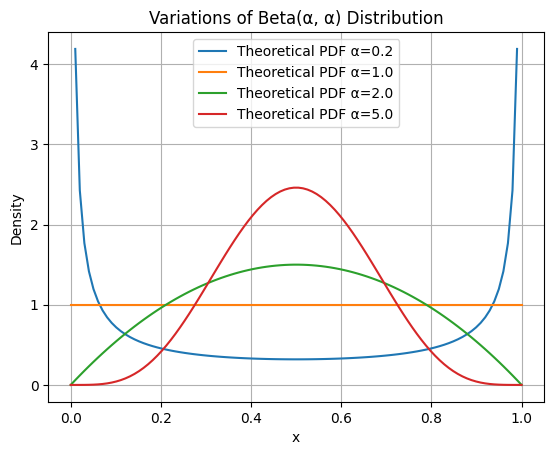

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# 定义不同的 α 值
alpha_values = [0.2, 1.0, 2.0, 5.0]
samples = []

# 为每个 α 值生成样本
for alpha in alpha_values:
    sample = beta.rvs(a=alpha, b=alpha, size=1000)
    samples.append(sample)

# # 绘制概率密度图
# plt.figure(figsize=(10, 6))
# for i, alpha in enumerate(alpha_values):
#     plt.hist(samples[i], bins=30, density=True, alpha=0.5, label=f'α={alpha}')

# 绘制 Beta 分布的理论概率密度
x = np.linspace(0, 1, 100)
for alpha in alpha_values:
    y = beta.pdf(x, a=alpha, b=alpha)
#     y = (y-np.min(y)) / (np.max(y) - np.min(y))
    plt.plot(x, y, label=f'Theoretical PDF α={alpha}')

plt.title("Variations of Beta(α, α) Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

In [1]:
import torch

# 检查是否有可用的 CUDA 设备
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available!
Device count: 1
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
